This notebook presents a simple use of our algorithm on the MNIST dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Fix seed for reproductibility
np.random.seed(42)

# Data Preparation

Open the data from sklearn with the **associated labels**. 

Labels are not used for clustering but allow to easily create constraints and evaluate the performances of the model.

In [3]:
from sklearn.datasets import load_digits

In [4]:
data, labels = load_digits(return_X_y = True)
classes = len(np.unique(labels))

In [5]:
classes

10

In [6]:
print("Dataset contains {} points in {} classes".format(len(data), classes))

Dataset contains 1797 points in 10 classes


# Create constraints

From the extracted labels we can create pairwise **must link** and **cannot link constraints**.  
For real case application, labels are unknown, constraints would be obtained from experts as +1 (must link) and -1 (cannot link) constraints.

In [7]:
from constrainedclustering.utils.constraint import random_indices, generate_constraint

We create *500* random constraints only on the first **1000** points

In [8]:
train = np.arange(1000)

In [9]:
indices =  random_indices(train, 500)
constraints = generate_constraint(labels, indices)

In [10]:
constraints = constraints.todense()

# Apply algorithm

In [11]:
from sklearn.cluster import KMeans
from constrainedclustering.utils.metrics import evalSplit
from constrainedclustering.utils.clustering import Clustering
from constrainedclustering.models.kernel_opt import kernel_clustering
from constrainedclustering.kernels.features import produce_kernels, normalize_and_check_kernels

Ran on 12 March 2023 16:58:29
Local


In [12]:
performances = {} # Dictionary to store test performances for the different methods

Our algorithm is available in two versions: with and without approximation of kernels. Approximation of kernels allows to reduce the memory usage and complexity when the data dimensionalityis too large

### Without approximation

In [13]:
# Define the different kernels we want to compute
kernels_name = ['rbf', 'sigmoid', 'polynomial', 
                'laplacian', 'linear']

# Define options on the kernels computation
kernel_args = {"normalize": "expectation", 
               "check_method": "trivial", 
               "clip": True}

# Compute and save kernels 
## As kernels computation is slow, the function saves it in a local folder
names, kernels = produce_kernels('asd', kernels_name, data, n_jobs = -4)
names, kernels = normalize_and_check_kernels(names, kernels, classes, n_jobs = -4, **kernel_args)

OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.


Kernels cannot be saved at /workspace/MasterThesis/Autoencoder/constrainedclustering/kernel_files/asd/scaled.npz 0


KeyboardInterrupt: 

In [39]:
# Define the clustering algorithm to use
clustering = Clustering.create("kmeans", classes = classes, constraint_matrix = constraints)

In [40]:
assignment = kernel_clustering(kernels, clustering, constraints)

In [41]:
performances["Without Approx"] = evalSplit(assignment, labels, train)['test']

### With approximation

In [43]:
kernel_args = {"normalize": "approximation"}

# Compute the kernels approximation
names, kernels = produce_kernels('mnist', kernels_name, data, n_jobs = -4, approximation = True)
names, kernels = normalize_and_check_kernels(names, kernels, classes, n_jobs = -4, **kernel_args)

In [44]:
assignment = kernel_clustering(kernels, clustering, constraints, kernel_approx = True)

In [45]:
performances["With Approx"] = evalSplit(assignment, labels, train)['test']

## Kmeans

For comparison, we compute a standard kmeans and evaluate it on the same test split

In [46]:
assignment = KMeans(classes).fit_predict(data)

 /usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [47]:
performances["Kmeans"] = evalSplit(assignment, labels, train)['test']

Here is a simple comparison on the test set

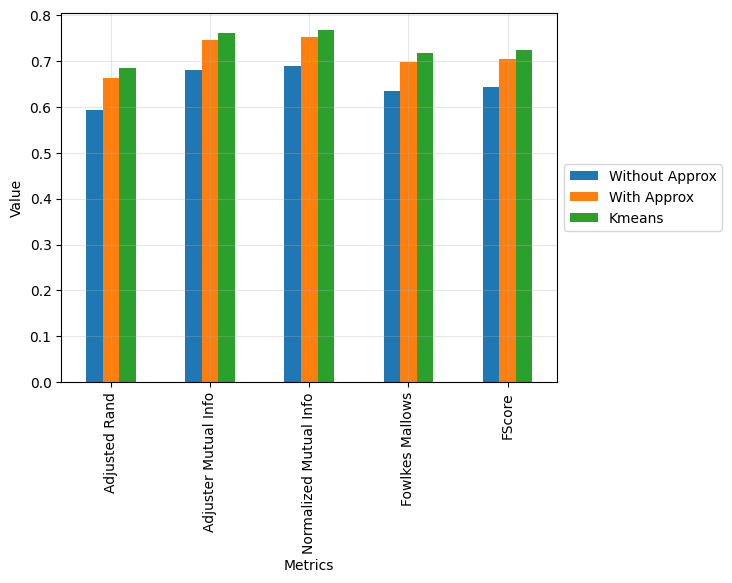

In [48]:
pd.DataFrame(performances).plot.bar()
plt.grid(alpha = 0.3)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))